In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # Disable the warning
from scipy.stats import norm
import matplotlib.ticker as ticker
%matplotlib widget

In [11]:
hits = pd.read_hdf(f"../config/ATPC_0nubb.h5", 'MC/hits')

display(hits)

FileNotFoundError: File ../config/ATPC_0nubb.h5 does not exist

In [ ]:
# Mean energy per e-. This splits up each G4 into E_hit/E_mean electrons
E_mean = 24.8e-6 # [eV]

# Function to smear the number of electrons in each hit by the fano factor
def smear_energy(N, resolution):
    if N < 10:
        return np.random.poisson(N)  # Poisson for small N
    else:
        # sigma = np.sqrt(N * 0.15) # 0.15 Fano factor
        if (resolution == 1):
            sigma = np.sqrt(N * 1.8) # 1% ER
        
        elif (resolution == 1.2):
            sigma = np.sqrt(N * 2.6) # 1.2% ER
        
        elif (resolution == 0.3):
            sigma = np.sqrt(N * 0.15) # 0.3% ER
        
        elif (resolution == 0.75):
            sigma = np.sqrt(N * 0.98) # 0.75% ER
        
        elif (resolution == 0.5):
            sigma = np.sqrt(N * 0.45) # 0.5% ER
        else:
            print("Error resoltion not defined, using default 1%")
            sigma = np.sqrt(N * 1.8) # 1% ER
        
        new_n = int(round(np.random.normal(N, sigma)))
        if (new_n < 0):
            return 1
        else:
            return new_n  # Apply Gauss+rounding

In [14]:
def FilterEventE(df, Emin, Emax, E_mean):

    event_energies = df.groupby("event_id").n.sum()*E_mean*1000

    passed_events = event_energies[ (event_energies >= Emin) & ((event_energies <= Emax))].index

    dfs_filtered = df[df["event_id"].isin(passed_events)]

    return dfs_filtered

In [ ]:
e_sum = []

dfs = []
dfs2 = []
dfs3 = []
dfs4 = []
dfs5 = []

for index, e in enumerate(hits.event_id.unique()):
    print("On Event:", e )

    if (e > 10000):
        break

    # Select the event
    event = hits[hits.event_id == e]

    # Calc number of electrons in a hit
    event["n"] = round(event["energy"]/E_mean)
    event2 = event.copy()
    event3 = event.copy()
    event4 = event.copy()
    event5 = event.copy()
    
    # Smear the energy by Fano amount
    event["n"]  = event["n"].apply(lambda x: smear_energy(x, resolution=1))
    # event2["n"] = event2["n"].apply(lambda x: smear_energy(x, resolution=0.5))
    # event3["n"] = event3["n"].apply(lambda x: smear_energy(x, resolution=1.2))
    # event4["n"] = event4["n"].apply(lambda x: smear_energy(x, resolution=0.3))
    event5["n"] = event5["n"].apply(lambda x: smear_energy(x, resolution=0.75))
    
    dfs.append(event)
    dfs2.append(event2)
    dfs3.append(event3)
    dfs4.append(event4)
    dfs5.append(event5)


dfs = pd.concat(dfs)
dfs2 = pd.concat(dfs2)
dfs3 = pd.concat(dfs3)
dfs4 = pd.concat(dfs4)
dfs5 = pd.concat(dfs5)
display(dfs)


NameError: name 'hits' is not defined

In [12]:

Eres = 0.75

min_E = 2458 - Eres*2458/100
max_E = 2458 + Eres*2458/100
print(min_E, max_E)

if (Eres == 1):
    filt_df = dfs
elif (Eres == 0.5):
    filt_df = dfs2
elif (Eres == 1.2):
    filt_df = dfs3
elif (Eres == 0.3):
    filt_df = dfs4
elif (Eres == 0.75):
    filt_df = dfs5


    
# filt_df = FilterEventE(dfs, min_E, max_E, E_mean)


# filt_df = pd.read_hdf("../config/ATPC_0nubb_EFilt.h5", "MC/hits5")

# event_energies = dfs.groupby("event_id").n.sum()*E_mean*1000
event_energies = filt_df.groupby("event_id").n.sum()*E_mean*1000
print(event_energies)



2439.565 2476.435


AttributeError: 'list' object has no attribute 'groupby'

NameError: name 'event_energies' is not defined

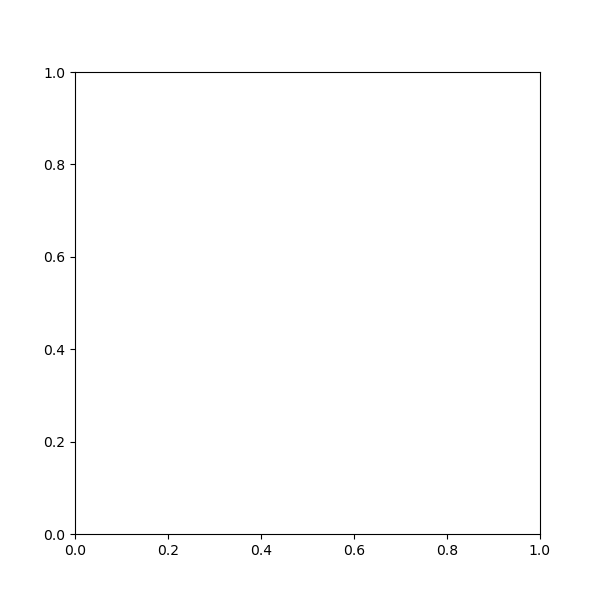

In [15]:
fig = plt.figure(figsize=(6,6));

plt.subplot(111);
# Plot histogram
counts, bins, _ = plt.hist(event_energies, bins=50, density=True, alpha=0.6, color='Teal', label=r'$0\nu\beta\beta$ + E smearing')
mu, sigma = norm.fit(event_energies)


# Plot the fitted Gaussian curve
x = np.linspace(bins[0], bins[-1], 200)
pdf = norm.pdf(x, mu, sigma)
plt.plot(x, pdf, 'r--', linewidth=2, label=f'Fit: μ={mu:.2f}, σ={sigma:.5f}')
plt.xlabel('Energy [keV]')
plt.ylabel("Amplitude [Arb]")
plt.legend()

print("FWMH:", 2.3548*sigma)
print("Eres FWMH:", 100*2.3548*sigma/mu)

plt.axhline(y=max(pdf)/2.0, color='r', linestyle='--')

plt.axvline(x=2.43342*1000, color='b', linestyle='--')
plt.axvline(x=2.48258*1000, color='b', linestyle='--')

# plt.savefig(f"plots/Technote/ERes_0.5percent.pdf", dpi=500)


In [71]:
# Make a plot of the background acceptance vs signal efficiency
N_sig = 10000.
N_Bi  = 10.e6
N_Tl  = 1.e6
N_single = 100e3
E_mean = 24.8e-6 # [eV]

nubb_meta = pd.read_hdf("../data/Eres/ATPC_0nubb_Efilt.h5", "MC/meta")
Bi_meta = pd.read_hdf("../data/Eres/ATPC_Bi_ion_Efilt.h5", "MC/meta")
Tl_meta = pd.read_hdf("../data/Eres/ATPC_Tl_ion_Efilt.h5", "MC/meta")
single_meta = pd.read_hdf("../data/Eres/ATPC_single_Efilt.h5", "MC/meta")

display(nubb_meta)
display(Bi_meta)
display(Tl_meta)
display(single_meta)


N_sig_win = int(nubb_meta.N_saved.iloc[0])
N_Bi_win  = int(Bi_meta.N_saved.iloc[0])
N_Tl_win  = int(Tl_meta.N_saved.iloc[0])
N_single_win  = int(single_meta.N_saved.iloc[0])
print(N_sig_win, N_Bi_win, N_Tl_win)

def LoadHits(file):
    hits1 = pd.read_hdf(f"../data/Eres/{file}", "MC/hits1")
    hits2 = pd.read_hdf(f"../data/Eres/{file}", "MC/hits2")
    hits3 = pd.read_hdf(f"../data/Eres/{file}", "MC/hits3")
    hits4 = pd.read_hdf(f"../data/Eres/{file}", "MC/hits4")
    hits5 = pd.read_hdf(f"../data/Eres/{file}", "MC/hits5")

    hits1["energy"] = hits1["n"]*E_mean
    hits2["energy"] = hits2["n"]*E_mean
    hits3["energy"] = hits3["n"]*E_mean
    hits4["energy"] = hits4["n"]*E_mean
    hits5["energy"] = hits5["n"]*E_mean
    return [hits1, hits2, hits3, hits4, hits5]


# Cut out events with Brem in the name
def ApplyEnergyWindowCut(df,threshold):

    event_energy = df.groupby("event_id").energy.sum()
    good_events = event_energy[(event_energy >= threshold) & (event_energy <= 2.5)].index
    df = df[df["event_id"].isin(good_events)]
    return df


def ApplyVariedEnergyThreshold(df, Eres):

    thresh_range = np.arange(1, -0.1, -0.1)

    wins = []
    for r in thresh_range:

        threshold = 2.458 - r * Eres*2.458/100
        # print(threshold)
        df = ApplyEnergyWindowCut(df,threshold)
        wins.append(len(df.event_id.unique()))

    return np.array(wins)


nubb_hits   = LoadHits("ATPC_0nubb_Efilt.h5")
Bi_hits = LoadHits("ATPC_Bi_ion_Efilt.h5")
Tl_hits = LoadHits("ATPC_Tl_ion_Efilt.h5")
single_hits = LoadHits("ATPC_single_Efilt.h5")

Eres = [1.2, 1.0, 0.75, 0.5, 0.3]


nubb_win = []
Bi_win = []
Tl_win = []
single_win = []

for index, res in enumerate(Eres):
    print("On resolution", res)
    # nubb_win.append(ApplyVariedEnergyThreshold(nubb_hits[index], res)/N_sig)
    # Bi_win.append  (0.37*ApplyVariedEnergyThreshold(Bi_hits[index], res)/N_Bi)
    # Tl_win.append  (0.37*ApplyVariedEnergyThreshold(Tl_hits[index], res)/N_Tl)
    nubb_win.append(ApplyVariedEnergyThreshold(nubb_hits[index], res)/N_sig_win)
    Bi_win.append  (ApplyVariedEnergyThreshold(Bi_hits[index], res)/N_Bi_win)
    Tl_win.append  (ApplyVariedEnergyThreshold(Tl_hits[index], res)/N_Tl_win)
    single_win.append  (ApplyVariedEnergyThreshold(single_hits[index], res)/N_single_win)


print(nubb_win[1])
print(Bi_win[3])
print(Tl_win[1])
print(single_win[1])



,N_gen,N_saved,N_savedE1,N_savedE2,N_savedE3,N_savedE4,N_savedE5,min_E,max_E,P,detsize,chamber_thick,seed,start_id
0,10000,9009,8753,8765,8742,8730,8778,2.3 MeV,2.6 MeV,25. bar,2.114 m,4 cm,9800,0


,N_gen,N_saved,N_savedE1,N_savedE2,N_savedE3,N_savedE4,N_savedE5,min_E,max_E,P,detsize,chamber_thick,seed,start_id
0,10000000,5465,3886,3714,3388,2568,705,2.3 MeV,2.6 MeV,25. bar,2.114 m,4 cm,9800,9800


,N_gen,N_saved,N_savedE1,N_savedE2,N_savedE3,N_savedE4,N_savedE5,min_E,max_E,P,detsize,chamber_thick,seed,start_id
0,1000000,10548,1861,1526,1120,751,452,2.3 MeV,2.6 MeV,25. bar,2.114 m,4 cm,9800,9800


,N_gen,N_saved,N_savedE1,N_savedE2,N_savedE3,N_savedE4,N_savedE5,min_E,max_E,P,detsize,chamber_thick,seed,start_id
0,100000,9628,1925,1608,1235,840,493,2.3 MeV,2.6 MeV,25 bar,2.114 m,4 cm,9800,0


9009 5465 10548
On resolution 1.2
On resolution 1.0
On resolution 0.75
On resolution 0.5
On resolution 0.3
[0.97291597 0.96359196 0.94838495 0.92907093 0.8997669  0.85614386
 0.80530581 0.74270174 0.66389166 0.57531358 0.48606949]
[0.46989936 0.41171089 0.33943275 0.27337603 0.21280878 0.16395242
 0.11875572 0.08380604 0.05837145 0.03751144 0.02488564]
[0.14467198 0.13737201 0.12883959 0.12267728 0.11509291 0.10788775
 0.10058779 0.09224498 0.0846606  0.07641259 0.06882821]
[0.16701288 0.15797673 0.15070627 0.14229331 0.13419194 0.12494807
 0.11746988 0.10874533 0.09991691 0.09171167 0.08340258]


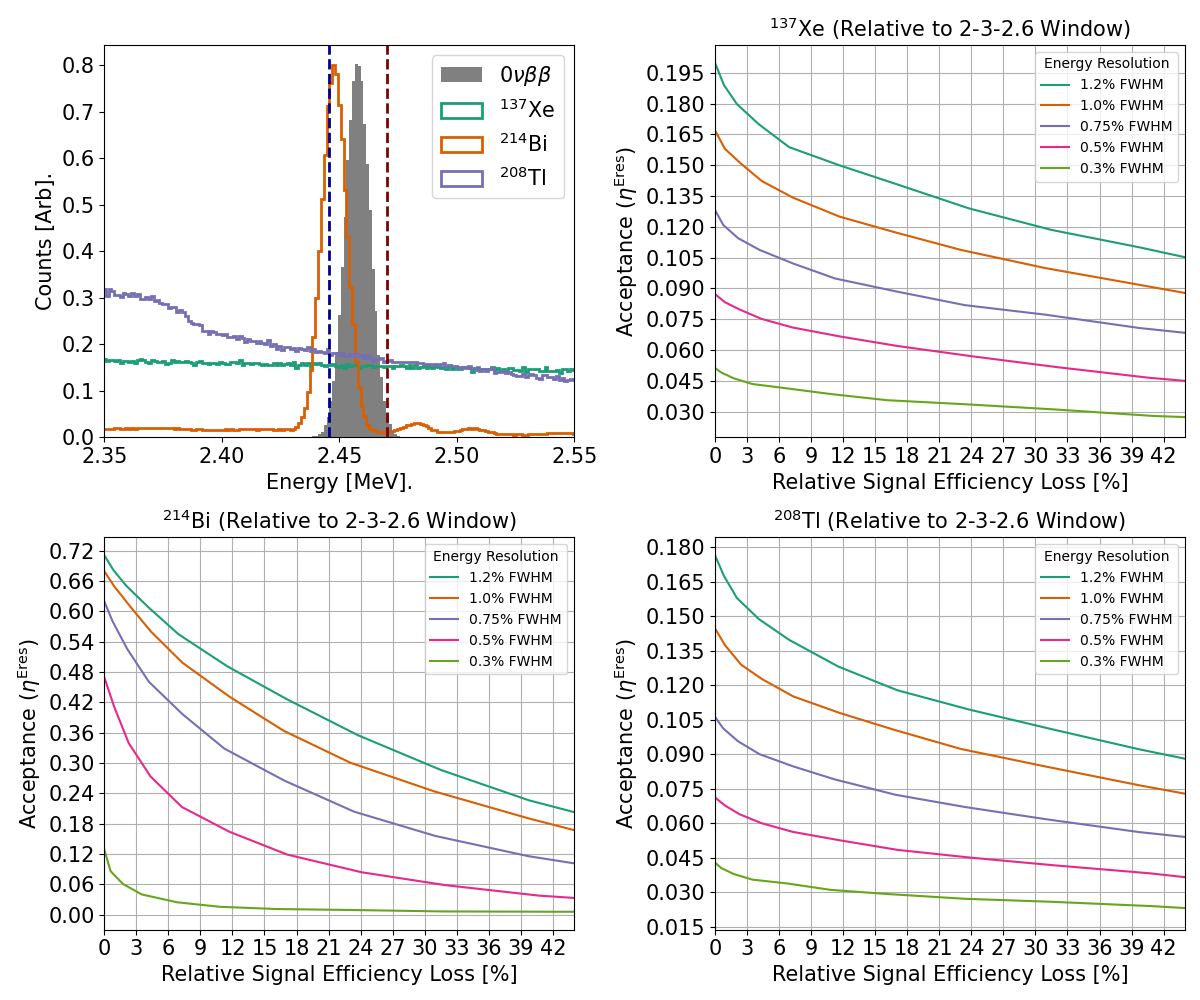

In [117]:
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=plt.cm.Dark2.colors)
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

for index, res in enumerate(Eres):
    ax[1,0].plot(nubb_win[index][0]*100 - nubb_win[index]*100, Bi_win[index], label = f"{res}% FWHM")
    ax[1,1].plot(nubb_win[index][0]*100 - nubb_win[index]*100, Tl_win[index], label = f"{res}% FWHM")
    ax[0,1].plot(nubb_win[index][0]*100 - nubb_win[index]*100, single_win[index], label = f"{res}% FWHM")

ax[1,0].set_title("$^{214}$Bi (Relative to 2-3-2.6 Window)", fontsize=15)
ax[1,0].set_xlabel("Relative Signal Efficiency Loss [%]", fontsize=15)
ax[1,0].set_ylabel(r"Acceptance ($\eta^{\mathrm{Eres}}$)", fontsize=15)
ax[1,0].tick_params(axis='both', which='both', labelsize=15)
ax[1,0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=15))
ax[1,0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=15))
ax[1,0].legend(title = "Energy Resolution")
ax[1,0].grid()
ax[1,0].set_xlim(0,44)

ax[1,1].set_title("$^{208}$Tl (Relative to 2-3-2.6 Window)", fontsize=15)
ax[1,1].set_xlabel("Relative Signal Efficiency Loss [%]", fontsize=15)
ax[1,1].set_ylabel(r"Acceptance ($\eta^{\mathrm{Eres}}$)", fontsize=15)
ax[1,1].tick_params(axis='both', which='both', labelsize=15)
ax[1,1].xaxis.set_major_locator(ticker.MaxNLocator(nbins=15))
ax[1,1].yaxis.set_major_locator(ticker.MaxNLocator(nbins=15))
ax[1,1].legend(title = "Energy Resolution")
ax[1,1].grid()
ax[1,1].set_xlim(0,44)

ax[0,1].set_title("$^{137}$Xe (Relative to 2-3-2.6 Window)", fontsize=15)
ax[0,1].set_xlabel("Relative Signal Efficiency Loss [%]", fontsize=15)
ax[0,1].set_ylabel(r"Acceptance ($\eta^{\mathrm{Eres}}$)", fontsize=15)
ax[0,1].tick_params(axis='both', which='both', labelsize=15)
ax[0,1].xaxis.set_major_locator(ticker.MaxNLocator(nbins=15))
ax[0,1].yaxis.set_major_locator(ticker.MaxNLocator(nbins=15))
ax[0,1].legend(title = "Energy Resolution")
ax[0,1].grid()
ax[0,1].set_xlim(0,44)
plt.tight_layout()

# Load in the files with larger window with 0.5% ERes

nubb_csv = pd.read_csv("../data/Eres/0nubb.csv")
single_csv = pd.read_csv("../data/Eres/single.csv")
Bi_ion_csv = pd.read_csv("../data/Eres/Bi_ion.csv")
Tl_ion_csv = pd.read_csv("../data/Eres/Tl_ion.csv")

# display(nubb_csv)
w1 = np.ones_like(nubb_csv["Energies"])/30000
w2 = np.ones_like(single_csv["Energies"])/30000
w3 = np.ones_like(Bi_ion_csv["Energies"])/40000
w4 = np.ones_like(Tl_ion_csv["Energies"])/30000

ax[0,0].hist(nubb_csv["Energies"], bins = np.linspace(2.3,2.6,250),   weights= w1, linewidth=2,color="grey", label = r"$0\nu\beta\beta$");
ax[0,0].hist(single_csv["Energies"], bins = np.linspace(2.3,2.6,250), weights= w2, histtype = "step",linewidth=2, label = "$^{137}$Xe");
ax[0,0].hist(Bi_ion_csv["Energies"], bins = np.linspace(2.3,2.6,250), weights= w3, histtype = "step",linewidth=2, label = "$^{214}$Bi");
ax[0,0].hist(Tl_ion_csv["Energies"], bins = np.linspace(2.3,2.6,250), weights= w4, histtype = "step",linewidth=2, label = "$^{208}$Tl");
ax[0,0].legend(fontsize=15)
ax[0,0].set_ylabel("Counts [Arb].", fontsize=15)
ax[0,0].set_xlabel("Energy [MeV].", fontsize=15)
ax[0,0].tick_params(axis='both', which='both', labelsize=15)

ax[0,0].axvline(x = 2.4456702, color = 'DarkBlue', linestyle="--", linewidth=2)
ax[0,0].axvline(x = 2.4702498, color = 'Maroon', linestyle="--", linewidth=2)
ax[0,0].set_xlim(2.35,2.55)
plt.tight_layout()


# Hide the unused subplot
# ax[1,1].axis('off')

plt.savefig(f"../../../Projects/Atmospheric TPC/PaperDraft/EnergyResolution.pdf")

In [69]:
# Lets derive some correction factors for analysis
# [ERes, cut size]

nubb_corr = nubb_win[2][6]/nubb_win[1][0]
print(nubb_corr)

# Background rejection factors are relative to 1% FWHM at 0% eff loss

Bi_corr = Bi_win[2][6]/Bi_win[1][0]
Tl_corr = Tl_win[2][6]/Tl_win[1][0]
single_corr = single_win[2][6]/single_win[1][0]
print(Bi_corr, Tl_corr, single_corr)


print(Bi_win[3][6], Tl_win[3][6], single_win[2][6])



0.8237307472903594
0.3896068928379106 0.5 0.5304726368159204
0.11875571820677036 0.04835039817974972 0.08859576235978396


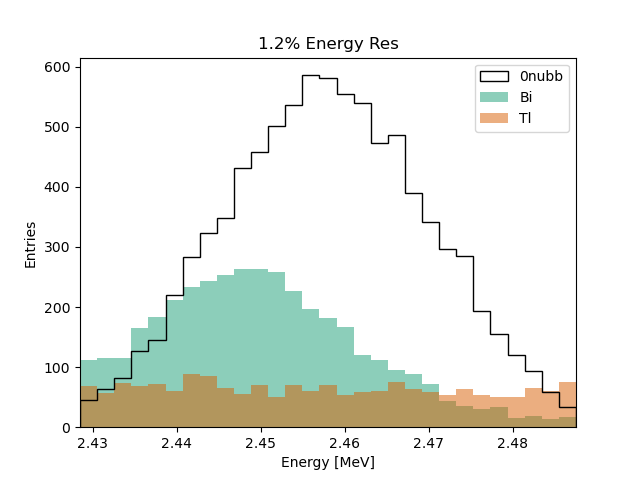

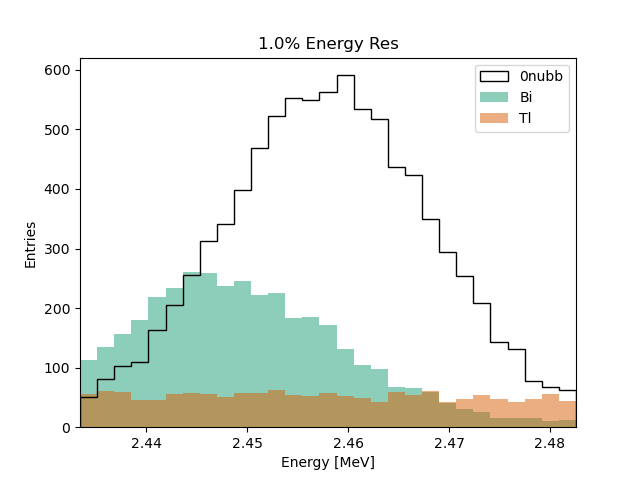

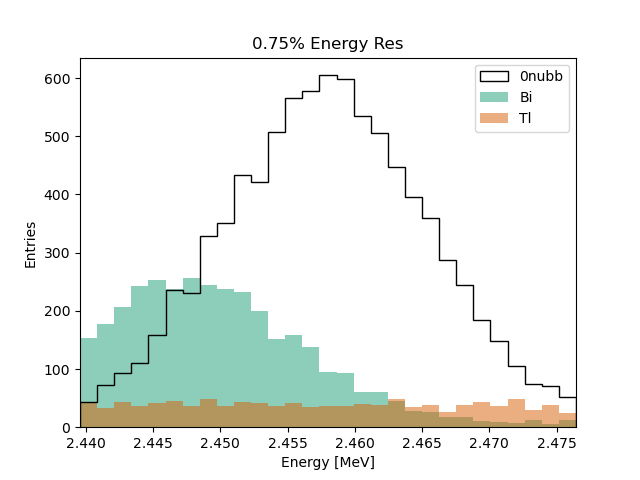

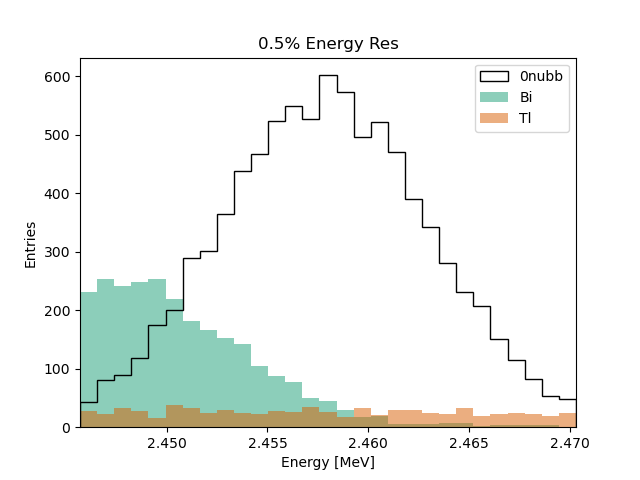

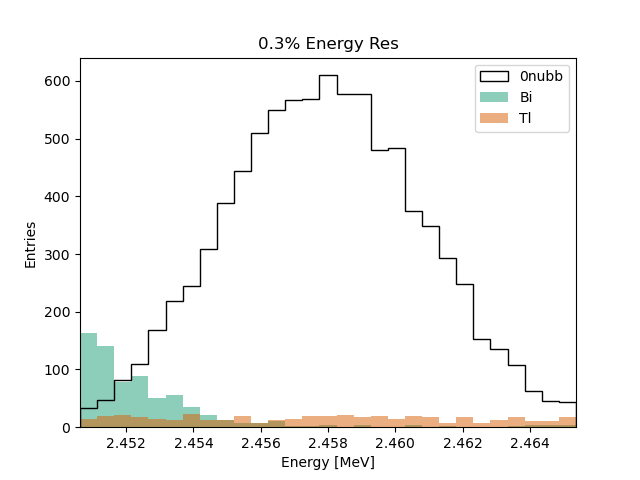

In [68]:
def ApplyVariedEnergyThresholdDF(df, Eres):

    threshold = 2.458 - Eres*2.458/100
    df = ApplyEnergyWindowCut(df,threshold)

    return df
Eres = [1.2, 1.0, 0.75, 0.5, 0.3]
for index, Eres in enumerate(Eres):
    # Eres = 1

    if (Eres == 1.2):
        nubb_filt = ApplyVariedEnergyThresholdDF(nubb_hits[0], 1.2)
        Bi_filt   = ApplyVariedEnergyThresholdDF(Bi_hits[0], 1.2)
        Tl_filt   = ApplyVariedEnergyThresholdDF(Tl_hits[0], 1.2)
    elif (Eres == 1):
        nubb_filt = ApplyVariedEnergyThresholdDF(nubb_hits[1], 1)
        Bi_filt   = ApplyVariedEnergyThresholdDF(Bi_hits[1], 1)
        Tl_filt   = ApplyVariedEnergyThresholdDF(Tl_hits[1], 1)
    elif (Eres == 0.75):
        nubb_filt = ApplyVariedEnergyThresholdDF(nubb_hits[2], 0.75)
        Bi_filt   = ApplyVariedEnergyThresholdDF(Bi_hits[2], 0.75)
        Tl_filt   = ApplyVariedEnergyThresholdDF(Tl_hits[2], 0.75)
    elif (Eres == 0.5):
        nubb_filt = ApplyVariedEnergyThresholdDF(nubb_hits[3], 0.5)
        Bi_filt   = ApplyVariedEnergyThresholdDF(Bi_hits[3], 0.5)
        Tl_filt   = ApplyVariedEnergyThresholdDF(Tl_hits[3], 0.5)
    elif (Eres == 0.3):
        nubb_filt = ApplyVariedEnergyThresholdDF(nubb_hits[4], 0.3)
        Bi_filt   = ApplyVariedEnergyThresholdDF(Bi_hits[4], 0.3)
        Tl_filt   = ApplyVariedEnergyThresholdDF(Tl_hits[4], 0.3)

    plt.figure()
    Emin = 2.458 - Eres*2.458/100
    Emax = 2.458 + Eres*2.458/100
    plt.hist(nubb_filt.groupby("event_id").energy.sum(), bins = np.linspace(Emin,Emax,30), histtype = "step", label = "0nubb", color = "k");
    plt.hist(Bi_filt.groupby("event_id").energy.sum(), bins = np.linspace(Emin,Emax,30), alpha = 0.5, label = "Bi");
    plt.hist(Tl_filt.groupby("event_id").energy.sum(), bins = np.linspace(Emin,Emax,30), alpha = 0.5, label = "Tl");
    plt.xlabel("Energy [MeV]")
    plt.ylabel("Entries")
    plt.title(f"{Eres}% Energy Res")
    plt.xlim(Emin, Emax)

    plt.legend()

In [ ]:
# Load in the files with larger window with 0.5% ERes

nubb_csv = pd.read_csv("../data/Eres/0nubb.csv")
single_csv = pd.read_csv("../data/Eres/single.csv")
Bi_ion_csv = pd.read_csv("../data/Eres/Bi_ion.csv")
Tl_ion_csv = pd.read_csv("../data/Eres/Tl_ion.csv")

# display(nubb_csv)

plt.figure()

w1 = np.ones_like(nubb_csv["Energies"])/30000
w2 = np.ones_like(single_csv["Energies"])/30000
w3 = np.ones_like(Bi_ion_csv["Energies"])/40000
w4 = np.ones_like(Tl_ion_csv["Energies"])/30000

plt.hist(nubb_csv["Energies"], bins = np.linspace(2.3,2.6,250),   weights= w1, linewidth=2,color="k", label = r"$0\nu\beta\beta$");
plt.hist(single_csv["Energies"], bins = np.linspace(2.3,2.6,250), weights= w2, histtype = "step",linewidth=2, label = "$^{137}$Xe");
plt.hist(Bi_ion_csv["Energies"], bins = np.linspace(2.3,2.6,250), weights= w3, histtype = "step",linewidth=2, label = "$^{214}$Bi");
plt.hist(Tl_ion_csv["Energies"], bins = np.linspace(2.3,2.6,250), weights= w4, histtype = "step",linewidth=2, label = "$^{208}$Tl");
plt.legend(fontsize=15)
plt.ylabel("Counts [Arb].", fontsize=15)
plt.xlabel("Energy [MeV].", fontsize=15)
plt.tick_params(axis='both', which='both', labelsize=15)

plt.axvline(x = 2.4456702, color = 'DarkBlue', linestyle="--")
plt.axvline(x = 2.4702498, color = 'Maroon', linestyle="--")
plt.tight_layout()
